<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Code Readability Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine the readability or unreadability of code generated by LLM applications.

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to classifying
  generated code as readable or unreadable using datasets with ground-truth
  labels
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [ ]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [ ]:
!pip install "arize-phoenix[experimental]" ipython matplotlib openai pycm scikit-learn tiktoken

In [ ]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.experimental.evals import (
    CODE_READABILITY_PROMPT_RAILS_MAP,
    CODE_READABILITY_PROMPT_TEMPLATE_STR,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in
addition to an evaluation prompt template against a benchmark datasets of
readable and unreadable code with ground-truth labels. Currently supported
datasets for this task include:

- openai_humaneval_with_readability

In [ ]:
dataset_name = "openai_humaneval_with_readability"
df = download_benchmark_dataset(task="code-readability-classification", dataset_name=dataset_name)
df.head()

,Unnamed: 0,task_id,prompt,canonical_solution,test,entry_point,readable,solution
0,0,HumanEval/0,"from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n """""" Check if in given list of numbers, are any two numbers closer to each other than\n given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n True\n """"""\n","for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n","\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.95) == True\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.8) == False\n assert candidate([1.0, 2.0, 3.0, 4.0, 5.0, 2.0], 0.1) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 1.0) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 0.5) == False\n\n",has_close_elements,True,"for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n"
1,1,HumanEval/1,"from typing import List\n\n\ndef separate_paren_groups(paren_string: str) -> List[str]:\n """""" Input to this function is a string containing multiple groups of nested parentheses. Your goal is to\n separate those group into separate strings and return the list of those.\n Separate groups are balanced (each open brace is properly closed) and not nested within each other\n Ignore any spaces in the input string.\n >>> separate_paren_groups('( ) (( )) (( )( ))')\n ['()', '(())', '(()())']\n """"""\n",result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate('(()()) ((())) () ((())()())') == [\n '(()())', '((()))', '()', '((())()())'\n ]\n assert candidate('() (()) ((())) (((())))') == [\n '()', '(())', '((()))', '(((())))'\n ]\n assert candidate('(()(())((())))') == [\n '(()(())((())))'\n ]\n assert candidate('( ) (( )) (( )( ))') == ['()', '(())', '(()())']\n",separate_paren_groups,True,result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n
2,2,HumanEval/2,"\n\ndef truncate_number(number: float) -> float:\n """""" Given a positive floating point number, it can be decomposed into\n and integer part (largest integer smaller than given number) and decimals\n (leftover part always smaller than 1).\n\n Return the decimal part of the number.\n >>> truncate_number(3.5)\n 0.5\n """"""\n",return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate(3.5) == 0.5\n assert abs(candidate(1.33) - 0.33) < 1e-6\n assert abs(candidate(123.456) - 0.456) < 1e-6\n",truncate_number,False,return((lambda x: (lambda y: y(x))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u)))))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u))))(lambda f: lambda x: x if x == 0 else f(x - 1) + 1)(number % 1.0))
3,3,HumanEval/3,"from typing import List\n\n\ndef below_zero(operations: List[int]) -> bool:\n """""" You're given a list of deposit and withdrawal operations on a ban

## Display Binary Readability Classification Template

View the default template used to classify readability. You can tweak this template and evaluate its performance relative to the default.

In [ ]:
print(CODE_READABILITY_PROMPT_TEMPLATE_STR)


You are a stern but practical senior software engineer who cares a lot about simplicity and
readability of code. Can you review the following code that was written by another engineer?
Focus on readability of the code. Respond with "readable" if you think the code is readable,
or "unreadable" if the code is unreadable or needlessly complex for what it's trying
to accomplish.

ONLY respond with "readable" or "unreadable"

Task Assignment:
```
{query}
```

Implementation to Evaluate:
```
{code}
```



The template variables are:

- **query:** the coding task asked by a user
- **code:** implementation of the coding task

## Configure the LLM

Configure your OpenAI API key.

In [ ]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

🔑 Enter your OpenAI API key: ··········


Instantiate the LLM and set parameters.

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [ ]:
df = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df = df.rename(
    columns={"prompt": "query", "solution": "code"},
)

## LLM Evals: Code Readability Classifications GPT-4

Run readability classifications against a subset of the data.

In [ ]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [ ]:
model("Hello world, this is a test if you are working?")

Eta:2023-10-09 03:37:26.264202 |█████████████████████████████| 100.0% (1/1) [00:02<00:00,  2.03s/it]


"Hello! I'm working perfectly. How can I assist you today?"

In [ ]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
)["label"]

Eta:2023-10-09 03:42:00.556508 |█████████████████████████| 100.0% (100/100) [04:30<00:00,  2.70s/it]



Evaluate the predictions against human-labeled ground-truth readability labels.

              precision    recall  f1-score   support

    readable       0.91      0.73      0.81        44
  unreadable       0.82      0.95      0.88        56

    accuracy                           0.85       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.85      0.85       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

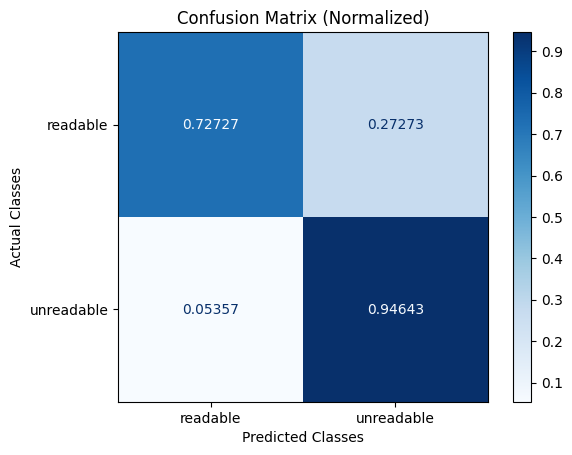

In [ ]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()
readability_classifications = (
    pd.Series(readability_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Inspecting evaluations

Because the evals are binary classifications, we can easily sample a few rows
where the evals deviated from ground truth and see what the actual code was in
that case.

In [ ]:
df["readability"] = readability_classifications
# inspect instances where ground truth was readable but evaluated to unreadable by the LLM
filtered_df = df.query('readable == False and readability == "readable"')

# inspect first 5 rows that meet this condition
result = filtered_df.head(5)
result

,Unnamed: 0,task_id,query,canonical_solution,test,entry_point,readable,code,readability
49,30,HumanEval/30,"\n\ndef get_positive(l: list):\n """"""Return only positive numbers in the list.\n >>> get_positive([-1, 2, -4, 5, 6])\n [2, 5, 6]\n >>> get_positive([5, 3, -5, 2, -3, 3, 9, 0, 123, 1, -10])\n [5, 3, 2, 3, 9, 123, 1]\n """"""\n",return [e for e in l if e > 0]\n,"\n\nMETADATA = {}\n\n\ndef check(candidate):\n assert candidate([-1, -2, 4, 5, 6]) == [4, 5, 6]\n assert candidate([5, 3, -5, 2, 3, 3, 9, 0, 123, 1, -10]) == [5, 3, 2, 3, 3, 9, 123, 1]\n assert candidate([-1, -2]) == []\n assert candidate([]) == []\n\n",get_positive,False,"return list(filter(lambda e: e > 0, l))",readable
56,79,HumanEval/79,"\ndef decimal_to_binary(decimal):\n """"""You will be given a number in decimal form and your task is to convert it to\n binary format. The function should return a string, with each character representing a binary\n number. Each character in the string will be '0' or '1'.\n\n There will be an extra couple of characters 'db' at the beginning and at the end of the string.\n The extra characters are there to help with the format.\n\n Examples:\n decimal_to_binary(15) # returns ""db1111db""\n decimal_to_binary(32) # returns ""db100000db""\n """"""\n","return ""db"" + bin(decimal)[2:] + ""db""\n","def check(candidate):\n\n # Check some simple cases\n assert candidate(0) == ""db0db""\n assert candidate(32) == ""db100000db""\n assert candidate(103) == ""db1100111db""\n assert candidate(15) == ""db1111db"", ""This prints if this assert fails 1 (good for debugging!)""\n\n # Check some edge cases that are easy to work out by hand.\n assert True, ""This prints if this assert fails 2 (also good for debugging!)""\n\n",decimal_to_binary,False,"def obscure_code(decimal):\n binary = bin(decimal)\n binary = binary[2:]\n prefix = ""db""\n suffix = ""db""\n result = prefix + binary + suffix\n return result\n\nprint(obscure_code(10))",readable
92,29,HumanEval/29,"from typing import List\n\n\ndef filter_by_prefix(strings: List[str], prefix: str) -> List[str]:\n """""" Filter an input list of strings only for ones that start with a given prefix.\n >>> filter_by_prefix([], 'a')\n []\n >>> filter_by_prefix(['abc', 'bcd', 'cde', 'array'], 'a')\n ['abc', 'array']\n """"""\n",return [x for x in strings if x.startswith(prefix)]\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([], 'john') == []\n assert candidate(['xxx', 'asd', 'xxy', 'john doe', 'xxxAAA', 'xxx'], 'xxx') == ['xxx', 'xxxAAA', 'xxx']\n",filter_by_prefix,False,"return list(filter(lambda x: x[:len(prefix)] == prefix, strings))",readable


## LLM Evals: Code Readability Classifications GPT-3.5

Run readability classifications against a subset of the data.

In [ ]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [ ]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
)["label"]

Eta:2023-10-09 03:57:47.927625 |█████████████████████████| 100.0% (100/100) [01:52<00:00,  1.12s/it]


              precision    recall  f1-score   support

    readable       0.73      0.93      0.82        44
  unreadable       0.93      0.73      0.82        56

    accuracy                           0.82       100
   macro avg       0.83      0.83      0.82       100
weighted avg       0.84      0.82      0.82       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

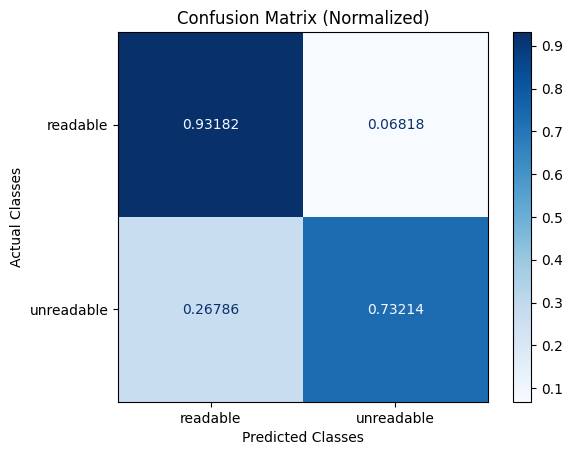

In [ ]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)